<h1>[문제 1] 수업 자료에서 제시하고 있는 다음 코드들을 BackEnd AI로 옮겨 실행하고 각 결과를 Backend AI내에 잘 정리하여 제시하기 

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

In [3]:
import sys

BASE_PATH = (os.path.join(os.path.pardir))
print(BASE_PATH)
CHECKPOINT_FILE_PATH = os.path.join(BASE_PATH, '_03_your_code', 'checkpoints')
if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(BASE_PATH, '_03_your_code', 'checkpoints'))




..


In [4]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss


In [5]:
from string import Template
class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

In [6]:
#RegressionTrainer 클래스 정의
from datetime import datetime
class RegressionTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader,
        transforms, run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        #MSE loss function을 사용
        self.loss_fn = nn.MSELoss()
    
    def do_train(self):
        self.model.train()

        loss_train = 0.0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            if self.transforms:
                input_train = self.transforms(input_train)

            output_train = self.model(input_train)

            loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)
            loss_train += loss.item()
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains

        return train_loss
    
    def do_validation(self):
        self.model.eval()

        loss_validation = 0.0
        num_validation = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_valid, target_valid = validation_batch
                input_valid = input_valid.to(device=self.device)
                target_valid = target_valid.to(device=self.device)

                if self.transforms:
                    input_valid = self.transforms(input_valid)

                output_valid = self.model(input_valid)
                
                loss_validation += self.loss_fn(output_valid.squeeze(dim=-1), target_valid).item()

                num_validation+=1

        validation_loss = loss_validation/num_validation

        return validation_loss
    
    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs+1):
            train_loss = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 1000 * epoch / elapsed_time.microseconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)
                
                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                self.wandb.log({
                    "Epoch":epoch,
                    "Training loss": train_loss,
                    "Validation loss": validation_loss,
                    "Training speed(epochs/sec)":epoch_per_second,
                })
                
                if early_stop:
                    break
        
        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

In [7]:
#비트코인 데이터 가져오기
import pandas as pd
def get_cryptocurrency_data(
        sequence_size=21, validation_size = 150, test_size = 30, target_column='Close',
        y_normalize=1.0e7, is_regression=True, 
):
        btc_krw_path = os.path.join(BASE_PATH, '_00_data', 'BTC_KRW.csv')
        df = pd.read_csv(btc_krw_path)
        row_size = len(df) # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

        date_list = df['Date']

        df = df.drop(columns=['Date'])
        data_size = row_size - sequence_size
        train_size = data_size - (validation_size+test_size)

        row_cursor = 0

        X_train_list = []
        y_train_regression_list = []
        y_train_classification_list = []
        y_train_date = []
        for idx in range(0, train_size):
                sequence_data=df.iloc[idx: idx+sequence_size].values
                X_train_list.append(torch.from_numpy(sequence_data))
                y_train_regression_list.append(df.iloc[idx+sequence_size][target_column])
                y_train_classification_list.append(
                        1 if df.iloc[idx+sequence_size][target_column] >= df.iloc[idx+sequence_size - 1][target_column] else 0
                )
                y_train_date.append(date_list[idx+sequence_size])
                row_cursor+=1

        X_train = torch.stack(X_train_list, dim=0).to(torch.float)
        y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalize
        y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

        #정규화
        m = X_train.mean(dim=0, keepdim=True)
        s = X_train.std(dim=0, keepdim=True)
        X_train = (X_train - m) / s

        X_validation_list = []
        y_validation_regression_list = []
        y_validation_classification_list = []
        y_validation_date = []

        for idx in range(row_cursor, row_cursor+validation_size):
                sequence_data = df.iloc[idx: idx+sequence_size].values
                X_validation_list.append(torch.from_numpy(sequence_data))
                y_validation_regression_list.append(df.iloc[idx+sequence_size][target_column])
                y_validation_classification_list.append(1 if df.iloc[idx+sequence_size][target_column] >= df.iloc[idx+sequence_size-1][target_column] else 0)
                y_validation_date.append(date_list[idx + sequence_size])
                row_cursor+=1

        X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
        y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalize
        y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

        X_validation = (X_validation-m)/s

        X_test_list = []
        y_test_regression_list = []
        y_test_classification_list = []
        y_test_date = []
        for idx in range(row_cursor, row_cursor + test_size):
                sequence_data = df.iloc[idx: idx+sequence_size].values
                X_test_list.append(torch.from_numpy(sequence_data))
                y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
                y_test_classification_list.append(1 if df.iloc[idx+sequence_size][target_column] > df.iloc[idx+sequence_size-1][target_column] else 0)
                y_test_date.append(date_list[idx+sequence_size])
                row_cursor+=1
        X_test = torch.stack(X_test_list, dim=0).to(torch.float)
        y_test_regression = torch.tensor(y_test_regression_list,dtype=torch.float32)/ y_normalize
        y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

        X_test = (X_test - m)/s

        if is_regression:
                return (
                        X_train, X_validation, X_test,
                        y_train_regression, y_validation_regression, y_test_regression,
                        y_train_date, y_validation_date, y_test_date
                )
        else:
                return(
                        X_train, X_validation, X_test,
                        y_train_classification, y_validation_classification, y_test_classification,
                        y_train_date, y_validation_date, y_test_date
                )


In [8]:

from torch.utils.data import Dataset, DataLoader

#비트코인 데이터 셋 클래스 정의
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y, is_regression=True):
        self.X = X
        self.y = y

        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y
    
    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(len(self.X), self.X.shape, self.y.shape)
        return str

In [9]:
def get_btc_krw_data(
    sequence_size = 21, validation_size=150, test_size=30, is_regression=True,  
):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
     = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size, 
        target_column='Close', y_normalize=1.0e7, is_regression=is_regression
    )
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)
    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True)

    return train_data_loader, validation_data_loader, test_data_loader

In [9]:
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

<h2>_01_code/_15_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py 실행결과 제시

In [10]:

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm1'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm1_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: kjs0820k (kjs0820k-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}


In [20]:
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm1_model = get_model()
lstm1_model.to(device)

optimizer = optim.Adam(lstm1_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm1_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()


cuda:0
[Epoch   1] T_loss: 9.09721, V_loss: 71.44367, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.032
[Epoch  30] T_loss: 4.09485, V_loss: 33.26944, V_loss decreased (71.44367 --> 33.26944). Saving model... | T_time: 00:00:00, T_speed: 0.035
[Epoch  60] T_loss: 0.66891, V_loss: 11.36540, V_loss decreased (33.26944 --> 11.36540). Saving model... | T_time: 00:00:01, T_speed: 0.078
[Epoch  90] T_loss: 0.32385, V_loss: 6.11726, V_loss decreased (11.36540 --> 6.11726). Saving model... | T_time: 00:00:02, T_speed: 0.154
[Epoch 120] T_loss: 0.21551, V_loss: 3.64818, V_loss decreased (6.11726 --> 3.64818). Saving model... | T_time: 00:00:03, T_speed: 0.296
[Epoch 150] T_loss: 0.15895, V_loss: 2.33096, V_loss decreased (3.64818 --> 2.33096). Saving model... | T_time: 00:00:04, T_speed: 0.655
[Epoch 180] T_loss: 0.11941, V_loss: 1.52984, V_loss decreased (2.33096 --> 1.52984). Saving model... | T_time: 00:00:05, T_speed: 1.219
[Epoch 210] T_loss: 0.09385, V_loss: 1.03819, V_loss dec

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
Training loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▂▃▁▁▁▂█▁▁▁▂▅▁▁
Validation loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1680
Training loss,0.01489
Training speed(epochs/sec),4.21506
Validation loss,0.33318


In [39]:
#test하는 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()
    test_model.eval()

    y_normalizer = 100
    print('[TEST DATA]')
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)
        
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
            idx,
            output.item() * y_normalizer,
            target.item() * y_normalizer,
            abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

In [9]:
from matplotlib import pyplot as plt
#학습된 모델을 가지고 예측하는 함수
def predict_all(test_model):
    y_normalizer = 100
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
    get_cryptocurrency_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True)

    #dataset 가져오기
    train_crypto_currency_dataset=CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset=CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset=CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]

    dataset_labels = [
        'train', 'validation', 'test'
    ]
    num = 0
    fig, axs = plt.subplots(3,1,figsize=(6,9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item()*y_normalizer)
            PREDICTION_Y.append(prediction.item()*y_normalizer)
            
            num+=1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()



<h2>_01_code/_15_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py 실행결과 제시

Model File: ../_03_your_code/checkpoints/lstm1_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_16643/3403488283.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

[TEST DATA]
 0: 933.61 <--> 1,373.29 (Loss:        439.68)
 1: 933.86 <--> 1,302.60 (Loss:        368.74)
 2: 924.74 <--> 1,073.52 (Loss:        148.78)
 3: 930.78 <--> 1,271.21 (Loss:        340.44)
 4: 933.09 <--> 1,319.45 (Loss:        386.35)
 5: 933.85 <--> 1,334.58 (Loss:        400.73)
 6: 926.16 <--> 1,125.35 (Loss:        199.19)
 7: 932.87 <--> 1,286.65 (Loss:        353.78)
 8: 929.22 <--> 1,272.01 (Loss:        342.79)
 9: 928.44 <--> 1,238.69 (Loss:        310.26)
10: 922.36 <--> 957.10 (Loss:         34.74)
11: 929.96 <--> 1,224.73 (Loss:        294.76)
12: 920.35 <--> 964.63 (Loss:         44.28)
13: 923.46 <--> 1,070.26 (Loss:        146.80)
14: 933.87 <--> 1,331.62 (Loss:        397.75)
15: 933.89 <--> 1,284.38 (Loss:        350.49)
16: 922.53 <--> 1,047.88 (Loss:        125.35)
17: 933.91 <--> 1,360.09 (Loss:        426.18)
18: 931.46 <--> 1,264.13 (Loss:        332.67)
19: 933.43 <--> 1,390.43 (Loss:        457.00)
20: 933.29 <--> 1,380.87 (Loss:        447.58)
21: 9

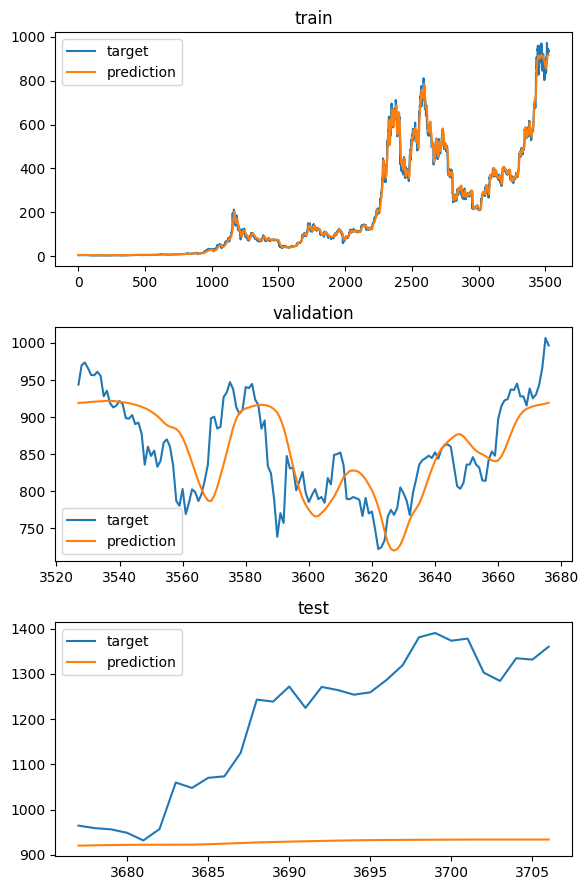

In [23]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm1'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm1_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)
predict_all(test_model)

In [14]:
#classification trainer 클래스 정의
class ClassificationTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader,
        transforms, run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        #loss function은 CrossEntropyLoss()
        self.loss_fn = nn.CrossEntropyLoss()
    
    def do_train(self):
        self.model.train()
        
        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train=input_train.to(device=self.device)
            target_train=target_train.to(device=self.device)

            if self.transforms:
                input_train = self.transforms(input_train)

            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)
            loss_train += loss.item()

            predicted_train = torch.argmax(output_train, dim=1)

            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

            num_trained_samples += len(input_train)
            num_trains+=1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train/num_trains
        train_accuracy = 100 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy
    
    def do_validation(self):
        self.model.eval()

        loss_valid = 0.0
        num_corrects_valid = 0
        num_valid_samples = 0
        num_valid = 0

        with torch.no_grad():
            for valid_batch in self.validation_data_loader:
                input_valid, target_valid = valid_batch
                input_valid = input_valid.to(device=self.device)
                target_valid = target_valid.to(device=self.device)

                if self.transforms:
                    input_valid = self.transforms(input_valid)

                output_valid = self.model(input_valid)
                loss_valid += self.loss_fn(output_valid, target_valid).item()

                predicted_valid = torch.argmax(output_valid, dim=1)
                num_corrects_valid += torch.sum(torch.eq(predicted_valid, target_valid)).item()

                num_valid_samples += len(input_valid)
                num_valid += 1

            valid_loss = loss_valid / num_valid
            valid_accuracy = 100*num_corrects_valid / num_valid_samples

            return valid_loss, valid_accuracy
        
    def train_loop(self):
        early_stopping = EarlyStopping(
                patience=self.wandb.config.early_stop_patience,
                delta=self.wandb.config.early_stop_delta,
                project_name=self.project_name,
                checkpoint_file_path=self.checkpoint_file_path,
                run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs+1):
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                valid_loss, valid_accuracy = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                message, early_stop = early_stopping.check_and_save(valid_loss, self.model)

                print(
                        f"[Epoch {epoch:>3}] "
                        f"T_loss: {train_loss:7.5f}, "
                        f"T_accuracy: {train_accuracy:6.4f} | "
                        f"V_loss: {valid_loss:7.5f}, "
                        f"V_accuracy: {valid_accuracy:6.4f} | "
                        f"{message} | "
                        f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                        f"T_speed: {epoch_per_second:4.3f}"
                )
                self.wandb.log({
                        "Epoch":epoch,
                        "Training loss": train_loss,
                        "Training accuracy (%)": train_accuracy,
                        "Validation loss": valid_loss,
                        "Validation accuracy (%)": valid_accuracy,
                        "Training speed (epochs/sec.)": epoch_per_second,
                })
                if early_stop:
                    break
        elapsed_time = datetime.now()-training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")            

In [11]:
def get_classification1_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            self.fcn = nn.Linear(in_features=256, out_features=n_output)
        
        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

<h2>_01_code/_15_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py 실행결과 제시

In [17]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm1'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm1_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}


In [18]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification1_model = get_classification1_model()
classification1_model.to(device)

optimizer = optim.Adam(classification1_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification1_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

cuda:0
[Epoch   1] T_loss: 0.69472, T_accuracy: 47.0371 | V_loss: 0.69408, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69055, T_accuracy: 53.4449 | V_loss: 0.69473, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69079, T_accuracy: 53.3031 | V_loss: 0.69363, V_accuracy: 47.3333 | V_loss decreased (0.69408 --> 0.69363). Saving model... | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69040, T_accuracy: 53.1897 | V_loss: 0.69381, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:03, T_speed: 30.000
[Epoch 120] T_loss: 0.69065, T_accuracy: 53.2464 | V_loss: 0.69368, V_accuracy: 46.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:04, T_speed: 30.000
[Epoch 150] T_loss: 0.69056, T_accuracy: 53.0196 | V_loss: 0.69350, V_accuracy: 46.0000 | V_loss decreased (0.69363 --> 0.69350). Saving model... | T_time: 00:00:05, T_speed:

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
Training loss,██████████████▇▇▇▇▇▆▆▆▆▅▅▄▅▄▄▄▃▃▃▃▂▂▂▁▁▁
Training speed (epochs/sec.),▁███████▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▃▃▃▃▂▂▂▁▁▄▃▄▃▆▅▇▇▇█▅▇▆▆█▆▅▇▅▆▆▅▅▅▅▆▅▅▆▆▆
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇█▇██
Epoch,1440
Training accuracy (%),63.28324
Training loss,0.57022
Training speed (epochs/sec.),26.66667
Validation accuracy (%),56


In [13]:
def classification1_test(test_model):
    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0

    print('[TEST DATA]')
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples+=len(input_test)
        test_accuracy = 100 * num_corrects_test/num_tested_samples

        print(f"Test Result: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(idx, torch.argmax(output).item(), target.item()))

<h2>_01_code/_15_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py 실행결과 제시

In [24]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm1'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm1_classification_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_classification1_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

classification1_test(test_model)



Model File: ../_03_your_code/checkpoints/lstm1_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
Test Result: 56.667%
 0:   1.00 <-->   0.00
 1:   0.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   0.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   0.00 <-->   1.00
11:   1.00 <-->   0.00
12:   0.00 <-->   1.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   1.00 <-->   1.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   0.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   0.00
27:   0.00 <-->   1.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00


/tmp/ipykernel_22437/2983706661.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

<h1>[문제 2]적절한 새로운 모델 구성 및 하이퍼파라미터 찾기

<h3> regression문제에서 적절한 새로운 모델 구성 및 하이퍼 파라미터 찾기

In [16]:
def get_reg_layer3_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True) #layer 개수 2 -> 3개로 변경
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

In [22]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm1_layer3_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}


In [23]:
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer3_model()
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

cuda:0
[Epoch   1] T_loss: 9.72736, V_loss: 74.60671, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027
[Epoch  30] T_loss: 3.44747, V_loss: 34.75292, V_loss decreased (74.60671 --> 34.75292). Saving model... | T_time: 00:00:00, T_speed: 0.030
[Epoch  60] T_loss: 0.66585, V_loss: 11.50453, V_loss decreased (34.75292 --> 11.50453). Saving model... | T_time: 00:00:02, T_speed: 0.812
[Epoch  90] T_loss: 0.32476, V_loss: 5.56637, V_loss decreased (11.50453 --> 5.56637). Saving model... | T_time: 00:00:03, T_speed: 1.697
[Epoch 120] T_loss: 0.21405, V_loss: 3.17195, V_loss decreased (5.56637 --> 3.17195). Saving model... | T_time: 00:00:04, T_speed: 1.065
[Epoch 150] T_loss: 0.15831, V_loss: 1.97603, V_loss decreased (3.17195 --> 1.97603). Saving model... | T_time: 00:00:05, T_speed: 1.543
[Epoch 180] T_loss: 0.12324, V_loss: 1.27254, V_loss decreased (1.97603 --> 1.27254). Saving model... | T_time: 00:00:06, T_speed: 1.911
[Epoch 210] T_loss: 0.09499, V_loss: 0.84534, V_loss dec

Epoch,▂▂▂▂▃▃▃▄▄▅▅▅▅▆▆▇▇███▁▁▁▂▂▃▃▃▄▄▅▅▅▅▆▇▇▇▇█
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁▁▂▁▁▁▂█▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▄▃▂▂▂▂▂
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1980
Training loss,0.01113
Training speed(epochs/sec),4.98997
Validation loss,0.1801


<h3>layer 2개에서 3개로 증가했을 때 validation loss = 0.15185

Model File: ../_03_your_code/checkpoints/lstm2_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_12126/36303575.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'))

[TEST DATA]
 0: 976.33 <--> 1,254.02 (Loss:        277.69)
 1: 977.70 <--> 1,302.60 (Loss:        324.91)
 2: 931.08 <--> 1,059.85 (Loss:        128.78)
 3: 975.72 <--> 1,264.13 (Loss:        288.41)
 4: 977.59 <--> 1,378.05 (Loss:        400.46)
 5: 977.22 <--> 1,390.43 (Loss:        413.21)
 6: 974.07 <--> 1,224.73 (Loss:        250.65)
 7: 971.22 <--> 1,238.69 (Loss:        267.47)
 8: 976.85 <--> 1,286.65 (Loss:        309.80)
 9: 951.03 <--> 959.09 (Loss:          8.07)
10: 972.82 <--> 1,272.01 (Loss:        299.19)
11: 977.11 <--> 1,380.87 (Loss:        403.76)
12: 976.97 <--> 1,319.45 (Loss:        342.48)
13: 975.04 <--> 1,271.21 (Loss:        296.17)
14: 976.69 <--> 1,259.24 (Loss:        282.55)
15: 968.89 <--> 1,243.20 (Loss:        274.31)
16: 977.69 <--> 1,284.38 (Loss:        306.70)
17: 960.65 <--> 1,073.52 (Loss:        112.88)
18: 977.56 <--> 1,331.62 (Loss:        354.06)
19: 940.53 <--> 931.83 (Loss:          8.69)
20: 951.56 <--> 964.63 (Loss:         13.07)
21: 977

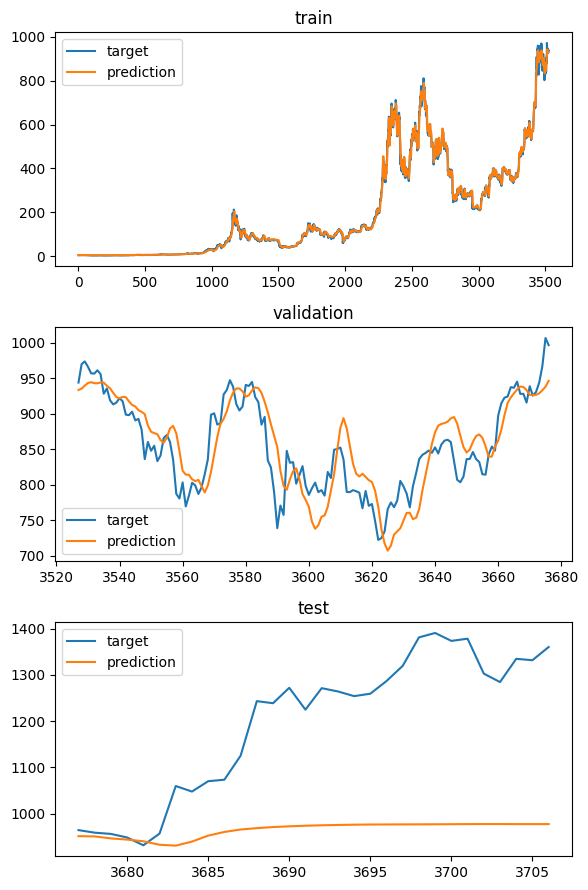

In [17]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)


test_model = get_reg_layer3_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)
predict_all(test_model)

wandb.finish()

In [ ]:
def get_reg_layer3_dropout_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True, dropout=0.2) #layer 개수 2 -> 3개로 변경, dropout 0.2 추가
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3_dropout(0.2)_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer3_dropout_model()
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

wandb: Currently logged in as: kjs0820k (kjs0820k-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 9.46768, V_loss: 73.62897, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.008
[Epoch  30] T_loss: 3.43917, V_loss: 32.64680, V_loss decreased (73.62897 --> 32.64680). Saving model... | T_time: 00:00:01, T_speed: 0.153
[Epoch  60] T_loss: 0.65776, V_loss: 11.05042, V_loss decreased (32.64680 --> 11.05042). Saving model... | T_time: 00:00:02, T_speed: 0.217
[Epoch  90] T_loss: 0.30790, V_loss: 5.21285, V_loss decreased (11.05042 --> 5.21285). Saving model... | T_time: 00:00:03, T_speed: 0.206
[Epoch 120] T_loss: 0.20513, V_loss: 2.99982, V_loss decreased (5.21285 --> 2.99982). Saving model... | T_time: 00:00:04, T_speed: 0.227
[Epoch 150] T_loss: 0.14885, V_loss: 1.85663, V_loss decreased (2.99982 --> 1.85663). Saving model... | T_time: 00:00:05, T_speed: 0.246
[Epoch 180] T_loss: 0.11697

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁█▂▂▁▁▆▂▂▁▁▃▂▂▁▆▄▂▂▂▂▃▃▂▂▂
Validation loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1980
Training loss,0.01532
Training speed(epochs/sec),2.05922
Validation loss,0.30354


<h3>layer 3개 드롭아웃 (0.2) 추가 validation loss = 0.18511

Model File: ../_03_your_code/checkpoints/lstm2_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_12126/491533433.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')

[TEST DATA]
 0: 938.46 <--> 1,254.02 (Loss:        315.56)
 1: 930.83 <--> 956.43 (Loss:         25.60)
 2: 932.54 <--> 1,070.26 (Loss:        137.72)
 3: 935.46 <--> 1,125.35 (Loss:        189.89)
 4: 938.83 <--> 1,360.09 (Loss:        421.27)
 5: 938.10 <--> 1,271.21 (Loss:        333.11)
 6: 936.95 <--> 1,238.69 (Loss:        301.74)
 7: 938.82 <--> 1,331.62 (Loss:        392.80)
 8: 938.72 <--> 1,390.43 (Loss:        451.72)
 9: 930.50 <--> 957.10 (Loss:         26.60)
10: 934.28 <--> 1,073.52 (Loss:        139.24)
11: 938.31 <--> 1,264.13 (Loss:        325.82)
12: 938.80 <--> 1,378.05 (Loss:        439.25)
13: 938.65 <--> 1,319.45 (Loss:        380.80)
14: 929.44 <--> 964.63 (Loss:         35.19)
15: 938.60 <--> 1,286.65 (Loss:        348.05)
16: 938.76 <--> 1,373.29 (Loss:        434.53)
17: 936.26 <--> 1,243.20 (Loss:        306.93)
18: 938.55 <--> 1,259.24 (Loss:        320.70)
19: 931.00 <--> 931.83 (Loss:          0.83)
20: 938.82 <--> 1,284.38 (Loss:        345.56)
21: 931.1

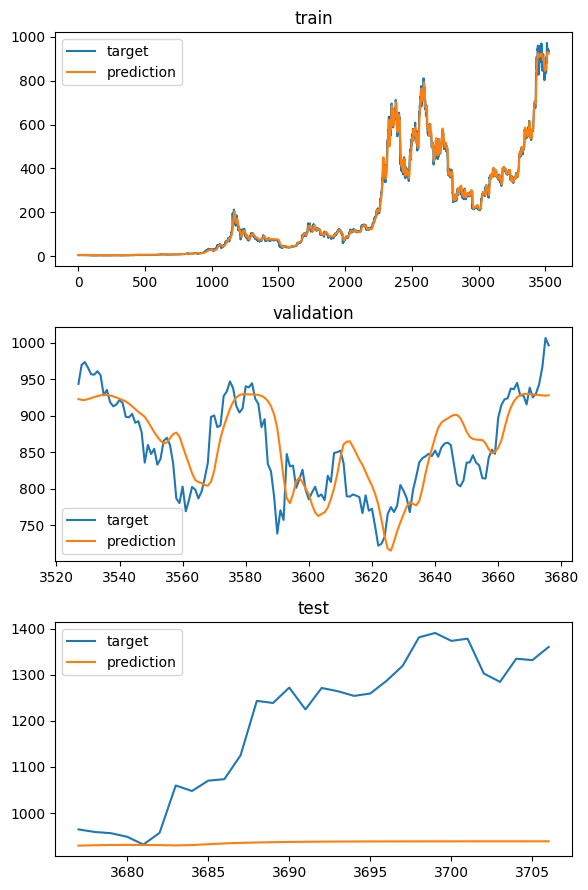

In [ ]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3_dropout(0.2)'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)


test_model = get_reg_layer3_dropout_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)
predict_all(test_model)

wandb.finish()

In [20]:
def get_reg_layer4_dropout_addLinear_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True, dropout=0.2) #layer 개수 2 -> 3개로 변경, dropout 0.2 추가
            self.fcn = nn.Linear(in_features=128, out_features=64)
            self.fcn2 = nn.Linear(in_features=64, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_dropout(0.2)_addLinear'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer4_dropout_addLinear_model()
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 9.10463, V_loss: 72.01867, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.019
[Epoch  30] T_loss: 2.24952, V_loss: 26.15116, V_loss decreased (72.01867 --> 26.15116). Saving model... | T_time: 00:00:01, T_speed: 0.215
[Epoch  60] T_loss: 0.38211, V_loss: 5.55055, V_loss decreased (26.15116 --> 5.55055). Saving model... | T_time: 00:00:02, T_speed: 0.242
[Epoch  90] T_loss: 0.14339, V_loss: 0.82507, V_loss decreased (5.55055 --> 0.82507). Saving model... | T_time: 00:00:03, T_speed: 0.205
[Epoch 120] T_loss: 0.08949, V_loss: 0.36097, V_loss decreased (0.82507 --> 0.36097). Saving model... | T_time: 00:00:04, T_speed: 0.230
[Epoch 150] T_loss: 0.07479, V_loss: 0.41665, Early stopping counter: 1 out of 30 | T_time: 00:00:05, T_speed: 0.246
[Epoch 180] T_loss: 0.06600, V_loss: 0.37196, Earl

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁█▁▁▂▁▁▂▁▁▂▁▁▂▁▁▂▁▁▂▁█▂▁▅▂▁▄▂▂▆▂▂▆▂▂▅▂
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3150
Training loss,0.01307
Training speed(epochs/sec),6.18356
Validation loss,0.08723


<h3>layer 4개 드롭아웃 (0.2) 추가 Linear(뉴런 64개 층) 추가 validation loss = 0.07780

Model File: ../_03_your_code/checkpoints/lstm2_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_12126/1892760306.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

[TEST DATA]
 0: 1,063.88 <--> 1,380.87 (Loss:        316.99)
 1: 943.51 <--> 956.43 (Loss:         12.91)
 2: 1,066.64 <--> 1,390.43 (Loss:        323.79)
 3: 1,052.13 <--> 1,264.13 (Loss:        212.00)
 4: 945.92 <--> 1,047.88 (Loss:        101.96)
 5: 1,072.29 <--> 1,284.38 (Loss:        212.09)
 6: 1,017.60 <--> 1,238.69 (Loss:        221.09)
 7: 926.14 <--> 957.10 (Loss:         30.96)
 8: 928.44 <--> 1,059.85 (Loss:        131.41)
 9: 1,072.92 <--> 1,378.05 (Loss:        305.13)
10: 935.84 <--> 931.83 (Loss:          4.00)
11: 1,058.05 <--> 1,254.02 (Loss:        195.97)
12: 957.93 <--> 964.63 (Loss:          6.70)
13: 991.36 <--> 1,125.35 (Loss:        133.98)
14: 1,068.63 <--> 1,334.58 (Loss:        265.95)
15: 1,060.11 <--> 1,286.65 (Loss:        226.53)
16: 1,000.20 <--> 1,243.20 (Loss:        243.00)
17: 1,070.31 <--> 1,373.29 (Loss:        302.98)
18: 1,074.07 <--> 1,302.60 (Loss:        228.53)
19: 1,029.33 <--> 1,272.01 (Loss:        242.68)
20: 1,039.94 <--> 1,224.73 (Lo

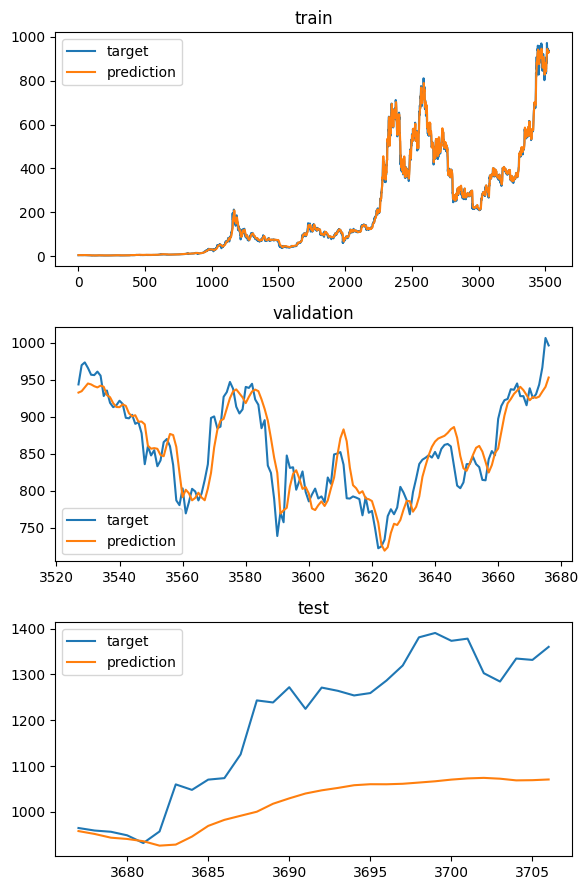

In [21]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_dropout(0.2)+addLinear'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)


test_model = get_reg_layer4_dropout_addLinear_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)
predict_all(test_model)

wandb.finish()

In [22]:
def get_reg_layer4_addLinear_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True) #layer 개수 4개로 변경 
            self.fcn = nn.Linear(in_features=128, out_features=64)
            self.fcn2 = nn.Linear(in_features=64, out_features=n_output) # Linear층 1개 더 추가

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_addLinear'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer4_addLinear_model()
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 9.97931, V_loss: 75.76043, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.027
[Epoch  30] T_loss: 2.98261, V_loss: 31.60865, V_loss decreased (75.76043 --> 31.60865). Saving model... | T_time: 00:00:01, T_speed: 1.818
[Epoch  60] T_loss: 0.42811, V_loss: 6.93226, V_loss decreased (31.60865 --> 6.93226). Saving model... | T_time: 00:00:02, T_speed: 5.049
[Epoch  90] T_loss: 0.13850, V_loss: 0.89854, V_loss decreased (6.93226 --> 0.89854). Saving model... | T_time: 00:00:03, T_speed: 0.994
[Epoch 120] T_loss: 0.08704, V_loss: 0.35029, V_loss decreased (0.89854 --> 0.35029). Saving model... | T_time: 00:00:04, T_speed: 1.518
[Epoch 150] T_loss: 0.07249, V_loss: 0.37203, Early stopping counter: 1 out of 30 | T_time: 00:00:05, T_speed: 2.008
[Epoch 180] T_loss: 0.06269, V_loss: 0.35029, Earl

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁█▆▂▃▂▂▂▁▁▁▁▁▁▁▁▁▇▆▂
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2520
Training loss,0.00952
Training speed(epochs/sec),12.8082
Validation loss,0.08851


<h3> lstm layer 4개 linear(뉴런이 64개인 층)추가 validation loss 0.05854

Model File: ../_03_your_code/checkpoints/lstm2_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_12126/4252485175.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

[TEST DATA]
 0: 1,090.71 <--> 1,224.73 (Loss:        134.01)
 1: 941.44 <--> 1,059.85 (Loss:        118.41)
 2: 1,033.97 <--> 1,125.35 (Loss:         91.38)
 3: 1,156.05 <--> 1,302.60 (Loss:        146.55)
 4: 1,129.69 <--> 1,319.45 (Loss:        189.76)
 5: 1,146.19 <--> 1,373.29 (Loss:        227.10)
 6: 1,135.04 <--> 1,380.87 (Loss:        245.83)
 7: 1,155.27 <--> 1,360.09 (Loss:        204.82)
 8: 1,154.27 <--> 1,284.38 (Loss:        130.12)
 9: 1,079.53 <--> 1,272.01 (Loss:        192.48)
10: 1,046.39 <--> 1,243.20 (Loss:        196.81)
11: 1,139.49 <--> 1,390.43 (Loss:        250.94)
12: 930.76 <--> 957.10 (Loss:         26.34)
13: 1,098.26 <--> 1,271.21 (Loss:        172.95)
14: 1,001.86 <--> 1,070.26 (Loss:         68.40)
15: 1,123.78 <--> 1,259.24 (Loss:        135.46)
16: 1,108.01 <--> 1,264.13 (Loss:        156.12)
17: 943.65 <--> 931.83 (Loss:         11.81)
18: 1,151.97 <--> 1,331.62 (Loss:        179.65)
19: 949.35 <--> 956.43 (Loss:          7.08)
20: 1,125.53 <--> 1,28

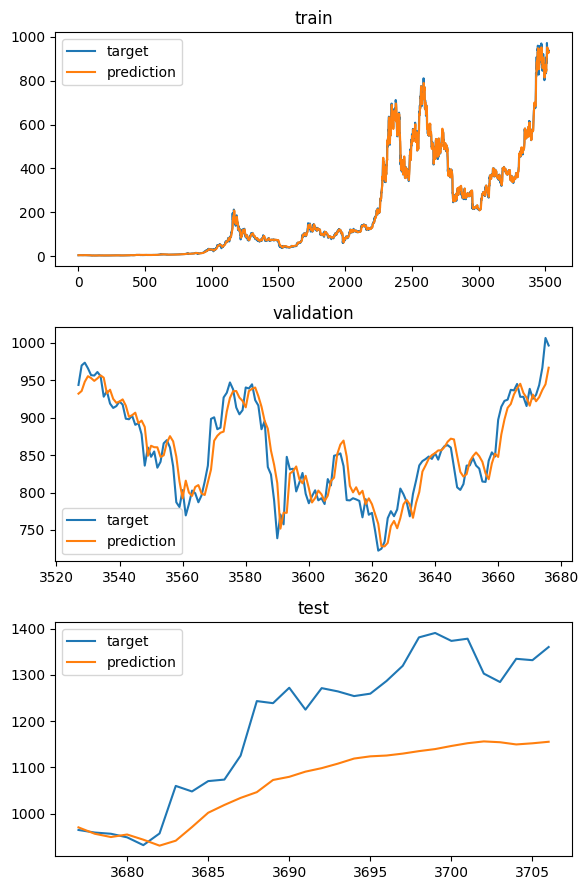

In [23]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4+addLinear'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)


test_model = get_reg_layer4_addLinear_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)
predict_all(test_model)

wandb.finish()

In [24]:
def get_reg_layer4_addLinear_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True) #layer 개수 4개로 변경 
            self.fcn = nn.Linear(in_features=128, out_features=64)
            self.fcn2 = nn.Linear(in_features=64, out_features=n_output) # Linear층 1개 더 추가

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_addLinear_weightdecay'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5, #weight_decay값 추가
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer4_addLinear_model() #기존 모델 그대로 사용
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 9.36976, V_loss: 73.14270, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.019
[Epoch  30] T_loss: 2.26916, V_loss: 25.32802, V_loss decreased (73.14270 --> 25.32802). Saving model... | T_time: 00:00:01, T_speed: 0.401
[Epoch  60] T_loss: 0.38370, V_loss: 5.74612, V_loss decreased (25.32802 --> 5.74612). Saving model... | T_time: 00:00:02, T_speed: 0.276
[Epoch  90] T_loss: 0.15354, V_loss: 1.07022, V_loss decreased (5.74612 --> 1.07022). Saving model... | T_time: 00:00:03, T_speed: 0.326
[Epoch 120] T_loss: 0.08958, V_loss: 0.34318, V_loss decreased (1.07022 --> 0.34318). Saving model... | T_time: 00:00:04, T_speed: 0.383
[Epoch 150] T_loss: 0.07299, V_loss: 0.35472, Early stopping counter: 1 out of 30 | T_time: 00:00:05, T_speed: 0.354
[Epoch 180] T_loss: 0.06374, V_loss: 0.34080, V_

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁▁▁▁▁▁█▇▂▂▁▁▁▁▁▁▁▁▁▄▃▂▂▂▂▂▁▁▁▁▆▃▃▂▂▂▂▂
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2700
Training loss,0.00942
Training speed(epochs/sec),4.82515
Validation loss,0.08093


<h3> lstm layer 4개 linear(뉴런이 64개인 층)추가 weight_decay = 1e-5 validation loss 0.05968

Model File: ../_03_your_code/checkpoints/lstm2_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_12126/1541299013.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

[TEST DATA]
 0: 1,024.37 <--> 1,125.35 (Loss:        100.97)
 1: 1,252.58 <--> 1,378.05 (Loss:        125.47)
 2: 1,244.95 <--> 1,380.87 (Loss:        135.92)
 3: 950.38 <--> 948.70 (Loss:          1.68)
 4: 1,250.66 <--> 1,373.29 (Loss:        122.63)
 5: 1,254.09 <--> 1,284.38 (Loss:         30.29)
 6: 1,240.64 <--> 1,319.45 (Loss:         78.80)
 7: 1,227.40 <--> 1,259.24 (Loss:         31.84)
 8: 929.25 <--> 957.10 (Loss:         27.85)
 9: 1,101.36 <--> 1,272.01 (Loss:        170.65)
10: 1,006.80 <--> 1,073.52 (Loss:         66.73)
11: 1,164.27 <--> 1,271.21 (Loss:        106.94)
12: 965.38 <--> 964.63 (Loss:          0.76)
13: 1,191.44 <--> 1,264.13 (Loss:         72.68)
14: 939.89 <--> 1,059.85 (Loss:        119.96)
15: 1,253.79 <--> 1,334.58 (Loss:         80.79)
16: 1,253.83 <--> 1,302.60 (Loss:         48.77)
17: 1,254.17 <--> 1,331.62 (Loss:         77.45)
18: 1,235.29 <--> 1,286.65 (Loss:         51.36)
19: 1,248.10 <--> 1,390.43 (Loss:        142.33)
20: 940.05 <--> 931.83

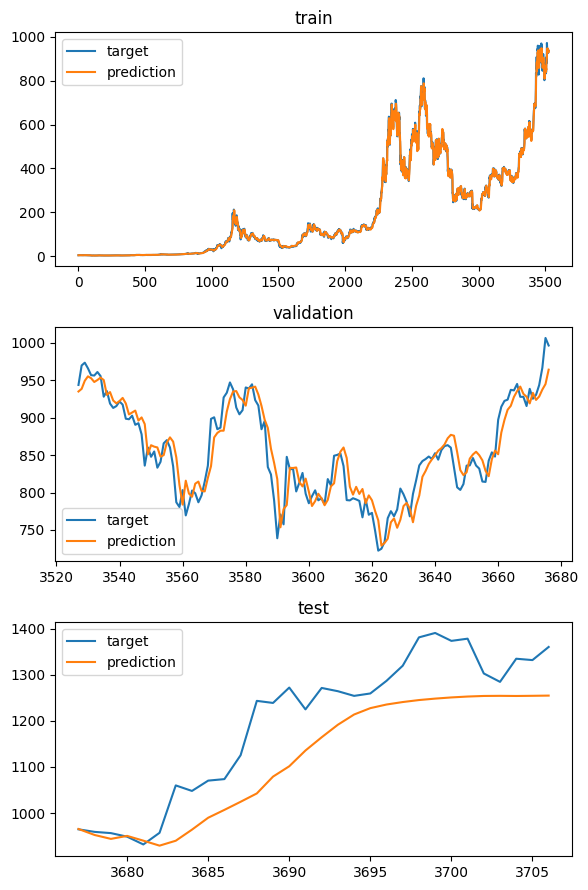

In [25]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4+addLinear'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)


test_model = get_reg_layer4_addLinear_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)
predict_all(test_model)

wandb.finish()

<h3>classification 문제에서 적절한 새로운 모델 구성 및 하이퍼 파라미터 찾기

In [29]:
def get_class_layer4_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=4, batch_first=True) #lstm layer 4개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=n_output)
        
        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer4_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 0.69501, T_accuracy: 47.0371 | V_loss: 0.69431, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69042, T_accuracy: 53.0479 | V_loss: 0.69478, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69034, T_accuracy: 53.2464 | V_loss: 0.69376, V_accuracy: 47.3333 | V_loss decreased (0.69431 --> 0.69376). Saving model... | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69079, T_accuracy: 53.0763 | V_loss: 0.69337, V_accuracy: 47.3333 | V_loss decreased (0.69376 --> 0.69337). Saving model... | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.69058, T_accuracy: 53.1330 | V_loss: 0.69353, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:05, T_sp

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██▇█
Training loss,██████████████████▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▁▄▁
Training speed (epochs/sec.),▁██▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▂▂▂▂▂▃▂▁▂▃▄▃▄▁▄▃▅▁▂▁▁▁▂▂▃▄▅▄▇▆█▄▅▅▆▆▅▅▅▄
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▄▆▇▄█
Epoch,1170
Training accuracy (%),61.72384
Training loss,0.58753
Training speed (epochs/sec.),20.89286
Validation accuracy (%),50.0


<h3> lstm layer 4개 validation loss = 0.69320, validation accuracy = 48.6667

In [31]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_class_layer4_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

classification1_test(test_model)

Model File: ../_03_your_code/checkpoints/lstm2_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
Test Result: 46.667%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   1.00
11:   0.00 <-->   1.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   1.00
15:   0.00 <-->   0.00
16:   0.00 <-->   1.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   1.00
22:   0.00 <-->   1.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   0.00
27:   0.00 <-->   0.00
28:   0.00 <-->   1.00
29:   0.00 <-->   1.00


/tmp/ipykernel_12126/1193775418.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

In [33]:
def get_class_layer3_addLinear1_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True) #lstm layer 4개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=128)
            self.fcn2 = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3_addLinear1_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer3_addLinear1_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 0.69470, T_accuracy: 47.0371 | V_loss: 0.69405, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69071, T_accuracy: 53.5299 | V_loss: 0.69473, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69047, T_accuracy: 53.2464 | V_loss: 0.69382, V_accuracy: 47.3333 | V_loss decreased (0.69405 --> 0.69382). Saving model... | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69039, T_accuracy: 53.1613 | V_loss: 0.69366, V_accuracy: 47.3333 | V_loss decreased (0.69382 --> 0.69366). Saving model... | T_time: 00:00:03, T_speed: 30.000
[Epoch 120] T_loss: 0.69047, T_accuracy: 53.1613 | V_loss: 0.69342, V_accuracy: 46.6667 | V_loss decreased (0.69366 --> 0.69342). Saving model... | T_

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training loss,████████████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▄▃▂▂▂▂▁
Training speed (epochs/sec.),▁█████▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▂▂▂▂▁▁▁▁▁▂▄▃▂▂▁▁▂▆▆▆▃▃▃▃▃▄▄▆▆▆▇▆▇▆▆▆█▆█▇
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▆▅▇▇▇███
Epoch,1410
Training accuracy (%),63.3683
Training loss,0.56508
Training speed (epochs/sec.),26.60377
Validation accuracy (%),59.33333


<h3> lstm layer 3개 validation loss = 0.69292, validation accuracy = 52.6667

In [34]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3_addLinear1'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_class_layer3_addLinear1_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

classification1_test(test_model)

Model File: ../_03_your_code/checkpoints/lstm2_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
Test Result: 43.333%
 0:   0.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   0.00 <-->   0.00
10:   1.00 <-->   0.00
11:   0.00 <-->   1.00
12:   0.00 <-->   0.00
13:   1.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   0.00
16:   1.00 <-->   0.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   0.00 <-->   1.00
20:   0.00 <-->   0.00
21:   0.00 <-->   1.00
22:   0.00 <-->   1.00
23:   0.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   0.00
26:   0.00 <-->   1.00
27:   1.00 <-->   1.00
28:   1.00 <-->   0.00
29:   0.00 <-->   1.00


/tmp/ipykernel_12126/1876298240.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

In [35]:
def get_class_layer3_addLinear1_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True) #lstm layer 4개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=128)
            self.fcn2 = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3_addLinear1_weightdecay_lr:1e-3_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer3_addLinear1_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 0.70086, T_accuracy: 47.0371 | V_loss: 0.69901, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69094, T_accuracy: 53.3881 | V_loss: 0.69496, V_accuracy: 47.3333 | V_loss decreased (0.69901 --> 0.69496). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69037, T_accuracy: 53.1613 | V_loss: 0.69390, V_accuracy: 47.3333 | V_loss decreased (0.69496 --> 0.69390). Saving model... | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 0.69059, T_accuracy: 53.1897 | V_loss: 0.69365, V_accuracy: 47.3333 | V_loss decreased (0.69390 --> 0.69365). Saving model... | T_time: 00:00:03, T_speed: 30.000
[Epoch 120] T_loss: 0.69010, T_accuracy: 53.1046 | V_loss: 0.69361, V_accuracy: 46.0000 | V_loss decreased (0.69365 --> 0.69361). 

In [36]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer3_addLinear1_weightdecay_lr:1e-3_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_class_layer3_addLinear1_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

classification1_test(test_model)

Model File: ../_03_your_code/checkpoints/lstm2_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
Test Result: 40.000%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   1.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   0.00
11:   0.00 <-->   1.00
12:   0.00 <-->   1.00
13:   0.00 <-->   1.00
14:   0.00 <-->   1.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   1.00 <-->   1.00
19:   0.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   0.00
22:   1.00 <-->   0.00
23:   0.00 <-->   1.00
24:   1.00 <-->   0.00
25:   0.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   0.00 <-->   1.00
29:   1.00 <-->   1.00


/tmp/ipykernel_12126/3272929953.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

In [13]:
def get_class_layer6_addLinear1_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=6, batch_first=True) #lstm layer 6개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=128)
            self.fcn2 = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer6_addLinear1_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}
project_name = 'lstm2_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer6_addLinear1_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kjs0820k (kjs0820k-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 0.69290, T_accuracy: 52.9629 | V_loss: 0.69256, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69067, T_accuracy: 53.0196 | V_loss: 0.69392, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69016, T_accuracy: 53.2464 | V_loss: 0.69363, V_accuracy: 47.3333 | Early stopping counter: 2 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69100, T_accuracy: 53.3598 | V_loss: 0.69329, V_accuracy: 47.3333 | Early stopping counter: 3 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epoch 120] T_loss: 0.69078, T_accuracy: 53.1046 | V_loss: 0.69305, V_accuracy: 49.3333 | Early stopping counter: 4 out of 30 | T_time: 00:00:08, T_speed: 15.000
[Epoch 150] T_loss: 0.69083,

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▁▂▂▁▂▁▂▁▂▁▂▁▂▂▃▃▃▃▃▃▃▃▂▃▃▃▃▄▄▄▄▄▆▇▇▆▇▇█
Training loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▃▃▂▃▁▁▃
Training speed (epochs/sec.),▁███████████████████████████████████████
Validation accuracy (%),▅▁▁▁▂▁▂▁▁▁▁▁▆▅▅█▆█▇█▇▇▆▅▅▅▅▂▁▁▅██▅▅▄█▅▇▇
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▁▃▁▁▁▂▂▁▂▂▄▄▄▆▆▆█
Epoch,1380
Training accuracy (%),55.28778
Training loss,0.67836
Training speed (epochs/sec.),13.93939
Validation accuracy (%),56


<h3> lstm layer 6개, addLinear validation loss = 0.69191, validation accuracy = 52.6667

In [17]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer6_addLinear1_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 0.0,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_class_layer6_addLinear1_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

classification1_test(test_model)

Model File: ../_03_your_code/checkpoints/lstm2_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
Test Result: 40.000%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   0.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   0.00
10:   0.00 <-->   0.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   0.00 <-->   1.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   0.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   0.00
22:   1.00 <-->   0.00
23:   1.00 <-->   0.00
24:   1.00 <-->   0.00
25:   1.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   0.00 <-->   1.00
29:   0.00 <-->   1.00


/tmp/ipykernel_22574/2546039462.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

In [19]:
def get_class_layer6_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=6, batch_first=True) #lstm layer 6개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer6_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}
project_name = 'lstm2_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer6_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 0.69209, T_accuracy: 50.4678 | V_loss: 0.69278, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69151, T_accuracy: 52.9629 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69278 --> 0.69173). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69133, T_accuracy: 52.9629 | V_loss: 0.69174, V_accuracy: 52.6667 | Early stopping counter: 1 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69135, T_accuracy: 52.9629 | V_loss: 0.69175, V_accuracy: 52.6667 | Early stopping counter: 2 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epoch 120] T_loss: 0.69169, T_accuracy: 52.9629 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 3 out of 30 | T_time: 00:00:08, T_speed: 15.000
[Epoch

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁███████████████████████████████████████
Training loss,█▄▂▂▅▂▃▇▂▃▃▆▁▅▄▃▃▂▄▅▂▃▃▂▃▂▃▂▂▁▂▂▃▃▃▂▄▁▃▄
Training speed (epochs/sec.),▁███████████████████████████████████████
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1260
Training accuracy (%),52.96286
Training loss,0.6915
Training speed (epochs/sec.),14.31818
Validation accuracy (%),52.66667


<h3> lstm layer 6개, addLinear validation loss = 0.69173, validation accuracy = 52.6667

In [20]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer6_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_class_layer6_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

classification1_test(test_model)

Model File: ../_03_your_code/checkpoints/lstm2_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
Test Result: 53.333%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   0.00
22:   1.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00


/tmp/ipykernel_22574/4048538036.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

<h3> lstm layer 6개 TEST결과 53.3333프로

<h1> [문제 3] 데이터 Feature 추가 후 성능 변화 확인하기

In [12]:
def get_cryptocurrency_nextopen_data(
        sequence_size=21, validation_size = 150, test_size = 30, target_column='Close',
        y_normalize=1.0e7, is_regression=True, 
):
        btc_krw_path = os.path.join(BASE_PATH, '_00_data', 'BTC_KRW.csv')
        df = pd.read_csv(btc_krw_path)
        row_size = len(df) # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

        date_list = df['Date']
        print(df.shape)
        df['Next_Open'] = df['Open'].shift(-1)  # Shift Open column upwards by one row
        print(df.shape)
        df = df.drop(columns=['Date'])  # Drop NaN rows after shift
        data_size = row_size - sequence_size
        train_size = data_size - (validation_size + test_size)
        print(df.shape)
        row_cursor = 0

        X_train_list = []
        y_train_regression_list = []
        y_train_classification_list = []
        y_train_date = []
        for idx in range(0, train_size):
                sequence_data=df.iloc[idx: idx+sequence_size].values
                X_train_list.append(torch.from_numpy(sequence_data))
                y_train_regression_list.append(df.iloc[idx+sequence_size][target_column])
                y_train_classification_list.append(
                        1 if df.iloc[idx+sequence_size][target_column] >= df.iloc[idx+sequence_size - 1][target_column] else 0
                )
                y_train_date.append(date_list[idx+sequence_size])
                row_cursor+=1

        X_train = torch.stack(X_train_list, dim=0).to(torch.float)
        y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalize
        y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

        #정규화
        m = X_train.mean(dim=0, keepdim=True)
        s = X_train.std(dim=0, keepdim=True)
        X_train = (X_train - m) / s

        X_validation_list = []
        y_validation_regression_list = []
        y_validation_classification_list = []
        y_validation_date = []

        for idx in range(row_cursor, row_cursor+validation_size):
                sequence_data = df.iloc[idx: idx+sequence_size].values
                X_validation_list.append(torch.from_numpy(sequence_data))
                y_validation_regression_list.append(df.iloc[idx+sequence_size][target_column])
                y_validation_classification_list.append(1 if df.iloc[idx+sequence_size][target_column] >= df.iloc[idx+sequence_size-1][target_column] else 0)
                y_validation_date.append(date_list[idx + sequence_size])
                row_cursor+=1

        X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
        y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalize
        y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

        X_validation = (X_validation-m)/s

        X_test_list = []
        y_test_regression_list = []
        y_test_classification_list = []
        y_test_date = []
        for idx in range(row_cursor, row_cursor + test_size):
                sequence_data = df.iloc[idx: idx+sequence_size].values
                X_test_list.append(torch.from_numpy(sequence_data))
                y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
                y_test_classification_list.append(1 if df.iloc[idx+sequence_size][target_column] > df.iloc[idx+sequence_size-1][target_column] else 0)
                y_test_date.append(date_list[idx+sequence_size])
                row_cursor+=1
        X_test = torch.stack(X_test_list, dim=0).to(torch.float)
        y_test_regression = torch.tensor(y_test_regression_list,dtype=torch.float32)/ y_normalize
        y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

        X_test = (X_test - m)/s

        if is_regression:
                return (
                        X_train, X_validation, X_test,
                        y_train_regression, y_validation_regression, y_test_regression,
                        y_train_date, y_validation_date, y_test_date
                )
        else:
                return(
                        X_train, X_validation, X_test,
                        y_train_classification, y_validation_classification, y_test_classification,
                        y_train_date, y_validation_date, y_test_date
                )

x_train, _, _ , _, _, _, _, _, _ = get_cryptocurrency_nextopen_data(
    sequence_size=21, validation_size = 150, test_size = 30, target_column='Close',
    y_normalize=1.0e7, is_regression=True
    )
print(x_train.shape)

(3728, 6)
(3728, 7)
(3728, 6)
torch.Size([3527, 21, 6])


In [11]:
def get_btc_krw_nextopen_data(
    sequence_size = 21, validation_size=150, test_size=30, is_regression=True,  
):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
     = get_cryptocurrency_nextopen_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size, 
        target_column='Close', y_normalize=1.0e7, is_regression=is_regression
    )
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)
    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True)

    return train_data_loader, validation_data_loader, test_data_loader

In [34]:
def get_reg_layer4_addLinear_nextopen_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True) #layer 개수 4개로 변경 
            self.fcn = nn.Linear(in_features=128, out_features=64)
            self.fcn2 = nn.Linear(in_features=64, out_features=n_output) # Linear층 1개 더 추가

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model = MyModel(n_input=6, n_output=1) #next_open 추가로 input feature 6개
    return my_model

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm3_layer4_addLinear_weightdecay'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5, #weight_decay값 추가
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm3_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_nextopen_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer4_addLinear_nextopen_model() #기존 모델 그대로 사용
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
(3728, 6)
(3728, 7)
(3728, 6)
cuda:0
[Epoch   1] T_loss: 8.98259, V_loss: 71.49409, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.026
[Epoch  30] T_loss: 3.21121, V_loss: 32.98477, V_loss decreased (71.49409 --> 32.98477). Saving model... | T_time: 00:00:01, T_speed: 0.284
[Epoch  60] T_loss: 0.56011, V_loss: 9.28835, V_loss decreased (32.98477 --> 9.28835). Saving model... | T_time: 00:00:02, T_speed: 0.637
[Epoch  90] T_loss: 0.16312, V_loss: 1.39799, V_loss decreased (9.28835 --> 1.39799). Saving model... | T_time: 00:00:03, T_speed: 1.139
[Epoch 120] T_loss: 0.08465, V_loss: 0.35689, V_loss decreased (1.39799 --> 0.35689). Saving model... | T_time: 00:00:04, T_speed: 1.869
[Epoch 150] T_loss: 0.06618, V_loss: 0.35464, V_loss decreased (0.35689 --> 0.35464). Saving model... | T_time: 00:00:05, T_speed: 1.05

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▅
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2460
Training loss,0.0102
Training speed(epochs/sec),56.20545
Validation loss,0.10533


In [10]:
from matplotlib import pyplot as plt
#학습된 모델을 가지고 예측하는 함수
def predict_all_nextopen(test_model):
    y_normalizer = 100
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = \
    get_cryptocurrency_nextopen_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True)

    #dataset 가져오기
    train_crypto_currency_dataset=CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset=CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset=CryptoCurrencyDataset(X=X_test, y=y_test)

    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]

    dataset_labels = [
        'train', 'validation', 'test'
    ]
    num = 0
    fig, axs = plt.subplots(3,1,figsize=(6,9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item()*y_normalizer)
            PREDICTION_Y.append(prediction.item()*y_normalizer)
            
            num+=1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()

def test_next(test_model):
    _, _, test_data_loader = get_btc_krw_nextopen_data()
    test_model.eval()

    y_normalizer = 100
    print('[TEST DATA]')
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)
        
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
            idx,
            output.item() * y_normalizer,
            target.item() * y_normalizer,
            abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))


In [22]:
def get_reg_layer4_addLinear_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm=nn.LSTM(input_size=n_input, hidden_size=128, num_layers=3, batch_first=True) #layer 개수 4개로 변경 
            self.fcn = nn.Linear(in_features=128, out_features=64)
            self.fcn2 = nn.Linear(in_features=64, out_features=n_output) # Linear층 1개 더 추가

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            x = self.fcn2(x)
            return x
        
    my_model = MyModel(n_input=5, n_output=1)
    return my_model

In [24]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4_addLinear_weightdecay_nextopenx'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5, #weight_decay값 추가
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm3_regression_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_data()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

lstm2_model = get_reg_layer4_addLinear_model() #기존 모델 그대로 사용
lstm2_model.to(device)

optimizer = optim.Adam(lstm2_model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

regression_trainer = RegressionTrainer(
    project_name=project_name,model=lstm2_model, optimizer=optimizer, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    transforms=None, run_time_str=run_time_name, wandb=wandb, device=device, checkpoint_file_path=CHECKPOINT_FILE_PATH
)
regression_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 9.46891, V_loss: 73.26875, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.026
[Epoch  30] T_loss: 3.66094, V_loss: 32.60477, V_loss decreased (73.26875 --> 32.60477). Saving model... | T_time: 00:00:01, T_speed: 2.452
[Epoch  60] T_loss: 0.43483, V_loss: 6.96940, V_loss decreased (32.60477 --> 6.96940). Saving model... | T_time: 00:00:02, T_speed: 0.600
[Epoch  90] T_loss: 0.15030, V_loss: 1.11024, V_loss decreased (6.96940 --> 1.11024). Saving model... | T_time: 00:00:03, T_speed: 0.789
[Epoch 120] T_loss: 0.08340, V_loss: 0.35746, V_loss decreased (1.11024 --> 0.35746). Saving model... | T_time: 00:00:04, T_speed: 0.692
[Epoch 150] T_loss: 0.06827, V_loss: 0.37387, Early stopping counter: 1 out of 30 | T_time: 00:00:05, T_speed: 0.709
[Epoch 180] T_loss: 0.06066, V_loss: 0.33861, V_

Epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
Training loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed(epochs/sec),▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▁▁▁▁▁
Validation loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2700
Training loss,0.01005
Training speed(epochs/sec),5.50188
Validation loss,0.07191


Model File: ../_03_your_code/checkpoints/lstm2_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_22574/3905902939.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

[TEST DATA]
 0: 965.38 <--> 964.63 (Loss:          0.76)
 1: 1,248.10 <--> 1,390.43 (Loss:        142.33)
 2: 1,252.58 <--> 1,378.05 (Loss:        125.47)
 3: 1,250.66 <--> 1,373.29 (Loss:        122.63)
 4: 989.77 <--> 1,070.26 (Loss:         80.49)
 5: 1,253.79 <--> 1,334.58 (Loss:         80.79)
 6: 1,024.37 <--> 1,125.35 (Loss:        100.97)
 7: 1,254.17 <--> 1,331.62 (Loss:         77.45)
 8: 1,235.29 <--> 1,286.65 (Loss:         51.36)
 9: 1,135.56 <--> 1,224.73 (Loss:         89.17)
10: 1,042.47 <--> 1,243.20 (Loss:        200.73)
11: 943.91 <--> 956.43 (Loss:         12.51)
12: 1,240.64 <--> 1,319.45 (Loss:         78.80)
13: 963.93 <--> 1,047.88 (Loss:         83.95)
14: 1,101.36 <--> 1,272.01 (Loss:        170.65)
15: 1,191.44 <--> 1,264.13 (Loss:         72.68)
16: 1,078.94 <--> 1,238.69 (Loss:        159.75)
17: 1,254.09 <--> 1,284.38 (Loss:         30.29)
18: 1,006.80 <--> 1,073.52 (Loss:         66.73)
19: 1,253.83 <--> 1,302.60 (Loss:         48.77)
20: 1,254.62 <--> 1,

/tmp/ipykernel_22574/3905902939.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_next_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device(

[TEST DATA]
 0: 1,122.32 <--> 1,254.02 (Loss:        131.69)
 1: 1,133.67 <--> 1,259.24 (Loss:        125.57)
 2: 1,168.73 <--> 1,284.38 (Loss:        115.65)
 3: 999.33 <--> 1,073.52 (Loss:         74.19)
 4: 960.63 <--> 1,047.88 (Loss:         87.24)
 5: 1,161.40 <--> 1,373.29 (Loss:        211.89)
 6: 1,165.62 <--> 1,334.58 (Loss:        168.96)
 7: 943.59 <--> 956.43 (Loss:         12.84)
 8: 1,104.58 <--> 1,264.13 (Loss:        159.55)
 9: 1,155.72 <--> 1,390.43 (Loss:        234.71)
10: 1,144.53 <--> 1,319.45 (Loss:        174.92)
11: 1,166.71 <--> 1,378.05 (Loss:        211.34)
12: 922.36 <--> 957.10 (Loss:         34.74)
13: 933.84 <--> 1,059.85 (Loss:        126.02)
14: 1,139.11 <--> 1,286.65 (Loss:        147.54)
15: 1,168.13 <--> 1,360.09 (Loss:        191.97)
16: 1,166.15 <--> 1,331.62 (Loss:        165.47)
17: 946.67 <--> 948.70 (Loss:          2.03)
18: 936.84 <--> 931.83 (Loss:          5.01)
19: 1,086.12 <--> 1,271.21 (Loss:        185.09)
20: 979.30 <--> 1,070.26 (Loss

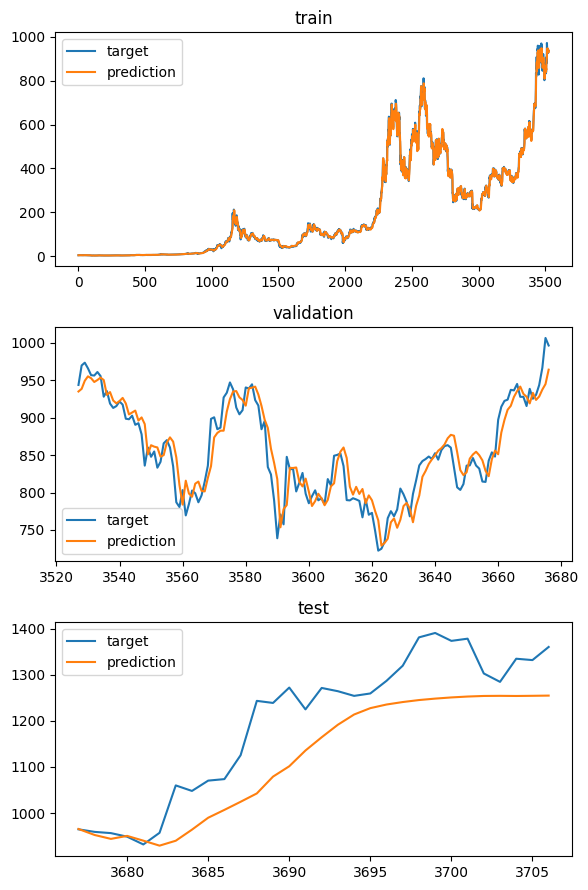

next open 추가
(3728, 6)
(3728, 7)
(3728, 6)


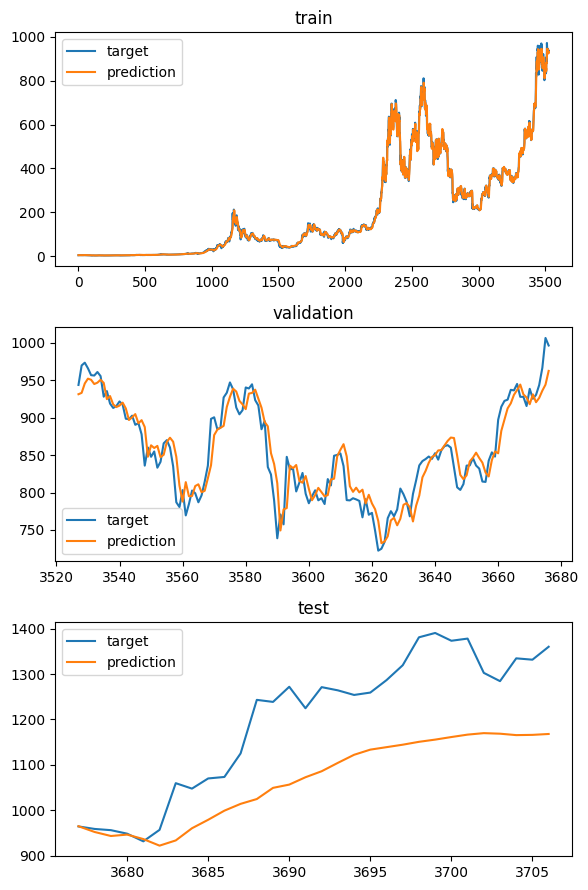

In [ ]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer4+addLinear'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm2_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)


test_model = get_reg_layer4_addLinear_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, "lstm3_regression_btc_krw_checkpoint_lstm2_layer4_addLinear_weightdecay_nextopenx2024-12-19_22-30-20.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test(test_model)

wandb.finish()

run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm3_layer4_addLinear_weightdecay'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5, #weight_decay값 추가
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}

project_name = 'lstm3_regression_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
test_next_model = get_reg_layer4_addLinear_nextopen_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, "lstm3_regression_btc_krw_checkpoint_lstm3_layer4_addLinear_weightdecay2024-12-19_21-53-52.pt")
print("Model File: {0}".format(latest_model_path))
test_next_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))

test_next(test_next_model)
print("기본")
predict_all(test_model)
print("==================================================================")
print("next open 추가")
predict_all_nextopen(test_next_model)


<h4>내용추가

In [16]:
def get_class_layer6_nextopen_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=6, batch_first=True) #lstm layer 6개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model =MyModel(n_input=6, n_output=2) #nextopen으로 feacture 개수 추가
    return my_model

def get_class_layer6_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=6, batch_first=True) #lstm layer 6개로 증가
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:,-1,:]
            x = self.fcn(x)
            return x
        
    my_model =MyModel(n_input=5, n_output=2)
    return my_model

In [18]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm3_layer6_nextopen_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}
project_name = 'lstm3_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, _ = get_btc_krw_nextopen_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer6_nextopen_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
(3728, 6)
(3728, 7)
(3728, 6)
cuda:0
[Epoch   1] T_loss: 0.69252, T_accuracy: 52.9629 | V_loss: 0.69191, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69126, T_accuracy: 52.9629 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69191 --> 0.69173). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69127, T_accuracy: 52.9629 | V_loss: 0.69172, V_accuracy: 52.6667 | V_loss decreased (0.69173 --> 0.69172). Saving model... | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69135, T_accuracy: 52.9629 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 1 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epoch 120] T_loss: 0.69143, T_accuracy: 52.9629 | V_loss: 0.69174, V_accuracy: 52.6667 | Early stopping counter: 2 ou

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,█▂▂▂▂▃▂▁▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▃▃▄▁▂▃▂▂▂
Training speed (epochs/sec.),▁████████████████████████████████
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▁▂▂▂▃▂▁▁▁▂▂▂▂▁▂▁▁▂▂▂▂▂▁▂▂▂▂▁▂▁
Epoch,960
Training accuracy (%),52.96286
Training loss,0.69138
Training speed (epochs/sec.),14.32836
Validation accuracy (%),52.66667


In [19]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm3_layer6_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}
project_name = 'lstm3_classification_btc_krw'
wandb.init(
    mode = 'online',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
print(wandb.config)
train_data_loader, validation_data_loader, test_data_loader = get_btc_krw_data(is_regression=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

classification_model = get_class_layer6_model()
classification_model.to(device)

optimizer = optim.Adam(classification_model.parameters(), lr = wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

classification1_trainer = ClassificationTrainer(
    project_name, classification_model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_name, wandb, device, CHECKPOINT_FILE_PATH
)
classification1_trainer.train_loop()

wandb.finish()

{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06}
cuda:0
[Epoch   1] T_loss: 0.69151, T_accuracy: 52.9629 | V_loss: 0.69306, V_accuracy: 52.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69131, T_accuracy: 52.9629 | V_loss: 0.69173, V_accuracy: 52.6667 | V_loss decreased (0.69306 --> 0.69173). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69135, T_accuracy: 52.9629 | V_loss: 0.69176, V_accuracy: 52.6667 | Early stopping counter: 1 out of 30 | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.69170, T_accuracy: 52.9629 | V_loss: 0.69173, V_accuracy: 52.6667 | Early stopping counter: 2 out of 30 | T_time: 00:00:06, T_speed: 15.000
[Epoch 120] T_loss: 0.69132, T_accuracy: 52.9629 | V_loss: 0.69175, V_accuracy: 52.6667 | Early stopping counter: 3 out of 30 | T_time: 00:00:08, T_speed: 15.000
[Epoch

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training loss,▅▃▄▇▃▃▃▄▃▄▅▃▃▇▅█▃▂▁▆█▆▃▇▅▄▅▇▆▅▆▄
Training speed (epochs/sec.),▁██████████████████▇████████████
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,930
Training accuracy (%),52.96286
Training loss,0.69138
Training speed (epochs/sec.),14.09091
Validation accuracy (%),52.66667


In [20]:
def classification1_test(test_model):
    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)
    print('[TEST DATA]')
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples+=len(input_test)
        test_accuracy = 100 * num_corrects_test/num_tested_samples

        print(f"Test Result: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(idx, torch.argmax(output).item(), target.item()))

def classification1_nextopen_test(test_model):
    test_model.eval()

    num_corrects_test = 0
    num_tested_samples = 0
    _, _, test_data_loader = get_btc_krw_nextopen_data(is_regression=False)
    print('[TEST DATA]')
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples+=len(input_test)
        test_accuracy = 100 * num_corrects_test/num_tested_samples

        print(f"Test Result: {test_accuracy:6.3f}%")

        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(idx, torch.argmax(output).item(), target.item()))

In [21]:
run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
run_time_name = 'lstm2_layer6_'+run_time_str
config = {
    'epochs': 10000,
    'batch_size': 2048,
    'validation_intervals': 30,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'early_stop_patience': 30,
    'early_stop_delta': 0.000001
}
project_name = 'lstm3_classification_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)

test_model = get_class_layer6_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
print("Model File: {0}".format(latest_model_path))
test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))
print("기본")
classification1_test(test_model)
wandb.finish(
)

project_name = 'lstm3_classification_btc_krw'
wandb.init(
    mode = 'disabled',
    project=project_name,
    notes='btc_krw experiment with lstm',
    name=run_time_name,
    config=config
)
test_next_model = get_class_layer6_nextopen_model()
latest_model_path = os.path.join(CHECKPOINT_FILE_PATH, "lstm3_classification_btc_krw_checkpoint_lstm3_layer6_nextopen_2024-12-19_22-19-13.pt")
test_next_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu')))
print("next open 추가후")
classification1_nextopen_test(test_next_model)

Model File: ../_03_your_code/checkpoints/lstm3_classification_btc_krw_checkpoint_latest.pt
기본


/tmp/ipykernel_29585/1198824021.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device('cpu'

[TEST DATA]
Test Result: 53.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   0.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   0.00
15:   1.00 <-->   1.00
16:   1.00 <-->   0.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   0.00
27:   1.00 <-->   0.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00
next open 추가후
(3728, 6)
(3728, 7)
(3728, 6)


/tmp/ipykernel_29585/1198824021.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_next_model.load_state_dict(torch.load(latest_model_path, map_location=torch.device(

[TEST DATA]
Test Result: 53.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   0.00
12:   1.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   1.00
16:   1.00 <-->   0.00
17:   1.00 <-->   1.00
18:   1.00 <-->   0.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   1.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   0.00
